### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

### Read and preprocess data 

In [2]:
dateparser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y %H:%M")
df = pd.read_csv("input_series_data.csv", parse_dates=['datetime'], date_parser=dateparser)
df.set_index('datetime', inplace=True)

In [3]:
df.head()

,variable
datetime,
2019-03-01 00:00:00,3601.934438
2019-03-01 00:10:00,3778.383666
2019-03-01 00:20:00,4067.039376
2019-03-01 00:30:00,4220.305584
2019-03-01 00:40:00,4213.950811


### Vizualise data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x115f98290>],
      dtype=object)

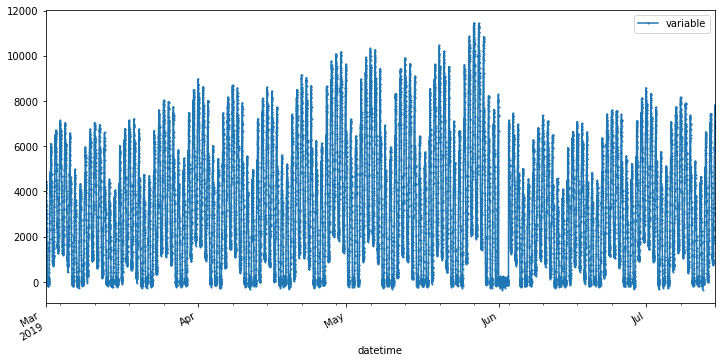

In [4]:
pd.plotting.register_matplotlib_converters()
df.plot(kind='line', subplots=True, figsize=(12,6), style='-o', markersize=1)

### Train model with optimal parameters

In [5]:
def optimal_model(data, horizon_days, input_freq):
    
    from fbprophet import Prophet
    from sklearn.model_selection import ParameterGrid
    from sklearn.metrics import mean_squared_error
        
    # transform data into prophet format
    idx_name = data.index.name
    data.index.rename('ds', inplace=True)
    data.rename({data.columns[0]: 'y'}, axis=1, inplace=True)
    
    # training and testing dataset
    df_train = data[:(data.index.max() - pd.Timedelta(horizon_days))]
    
    # define grid to do grid search
    params_grid = {'growth': ['linear'],
                   'seasonality_prior_scale': [5, 20],
                   #'changepoint_range': [0.8, 0.9],
                   'changepoint_prior_scale': [0.05, 0.1, 0.5],
                   'n_changepoints': [10, 30],
                   'seasonality_mode': ['additive']#, 'multiplicative']
                  }
    grid = ParameterGrid(params_grid)

    # fit Prophet and evaluate score
    list_score = []
    for p in grid:
        m=Prophet(**p)
        m.fit(df_train.reset_index())

        fcast_periods = len(np.arange(pd.Timedelta('0 days'), pd.Timedelta(horizon_days), pd.Timedelta(input_freq)))
        df_future = m.make_future_dataframe(periods=fcast_periods, freq=input_freq, include_history=False)
        forecast = m.predict(df_future)
        
        y_pred = forecast['yhat'].values
        y_true = data.tail(len(y_pred))['y'].values
        
        p['rmse'] = mean_squared_error(y_true, y_pred, squared=False)
        list_score.append(p)
        print(p)
    
    # get the parameters from the model that performed better
    best_model = min(list_score, key=lambda x:x['rmse'])
    print('RMSE: ', best_model['rmse'])
    best_model.pop('rmse', None)
    
    # fit model with best parameters
    m = Prophet(**best_model)
    m.fit(data.reset_index())
    
    return m

In [6]:
ts_model = optimal_model(df, horizon_days='30 days', input_freq='10T')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'changepoint_prior_scale': 0.05, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5, 'rmse': 2839.516407270497}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'changepoint_prior_scale': 0.05, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'rmse': 2839.7384847156754}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'changepoint_prior_scale': 0.05, 'growth': 'linear', 'n_changepoints': 30, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5, 'rmse': 2838.3884039002087}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'changepoint_prior_scale': 0.05, 'growth': 'linear', 'n_changepoints': 30, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'rmse': 2834.941611468376}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5, 'rmse': 2905.052323984994}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'rmse': 2911.3618353015313}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 30, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5, 'rmse': 2905.392471732238}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'changepoint_prior_scale': 0.1, 'growth': 'linear', 'n_changepoints': 30, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'rmse': 2902.3734664074045}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5, 'rmse': 2955.9947945839276}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'rmse': 2965.3473971252834}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 30, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5, 'rmse': 3021.06531786785}


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'n_changepoints': 30, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'rmse': 3002.6729408495576}
RMSE:  2834.941611468376


In [16]:
def plot_prophet(model, forecast):
    
    from fbprophet.plot import add_changepoints_to_plot    
    
    fig1 = model.plot(forecast)
    add_changepoints_to_plot(fig1.gca(), model, forecast)
    plt.show()
    fig2 = model.plot_components(forecast)
    plt.show()

In [17]:
def plot_forecast(data, forecast, title=None, m=None):
        
    plt.figure(figsize=(14,7))
    plt.plot(data, label='actuals', marker=m)
    plt.plot(forecast, label='prediction', marker=m)
    plt.ylabel('value')
    plt.xlabel('date')
    plt.title(title)
    plt.legend()
    plt.show()

In [18]:
def predict(model, horizon_days, input_freq):
    
    fcast_periods = len(np.arange(pd.Timedelta('0 days'), pd.Timedelta(horizon_days), pd.Timedelta(input_freq)))
    df_future = model.make_future_dataframe(periods=fcast_periods, freq=input_freq)

    # predict
    fcst = model.predict(df_future)

    # plot results
    plot_prophet(model, fcst)

    # save forecast results
    variable_pred = fcst[fcst['ds'] > df.index.max()][['ds','yhat']]\
        .rename(columns={'yhat': 'variable'})\
        .set_index('ds')
    
    # plot forecast
    plot_forecast(df.iloc[:,0], variable_pred, title='Forecasting variable', m='.')
    
    return variable_pred

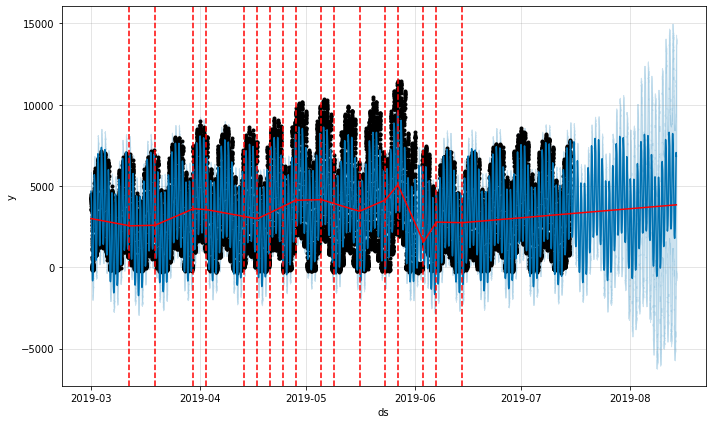

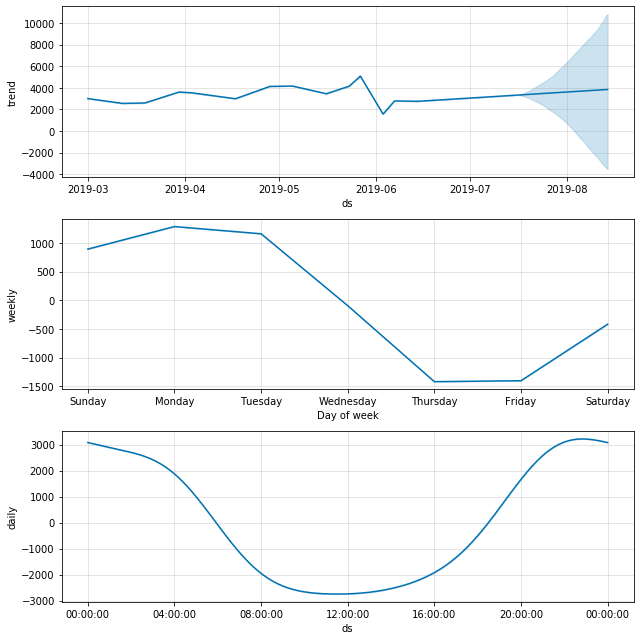

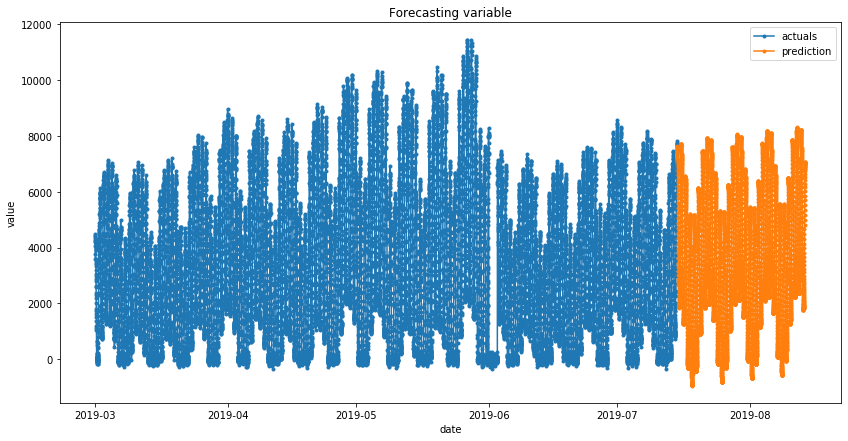

In [19]:
df_predictions = predict(model=ts_model, horizon_days='30 days', input_freq='10T')